# Letterboxd polarizing movies

## Summary

I made an EDA to identify controversial films, using the data of 4000 top users of some month, which is avilable in Kaggle:
https://www.kaggle.com/datasets/samlearner/letterboxd-movie-ratings-data


The process was the following:

Taking the ratings_export file, I aggregated the info to the movie-rating level to get a count of the different ratings for each movie. After that, I pivoted the data to turn each rating count into variables, and keep each observation at the level of movies. Finally, I normalized the counts of each movie to turn them into percentages and make them comparable across movies (please note that ratings are between 1 and 10, giving to each half star a value of 1).

Looking at the distribution of counts across movies, I discarded all the movies that had less than 100 ratings, in order to keep only movies that had a fairly solid distribution of ratings, and were at least "a little known".

After that, I built two variables: rating_1_4, and rating_8_10, that are the percentage of ratings that fall between the respective values. I did this to identify the proportion of people with strong opinions about the moives, as ratings between 1 and 4 (1/2 to 2 stars) are usually given to movies the users despised, and ratings between 8 and 10 (1/2 to 2 stars) are usually given to movies the user loved.

Using those two variables, looking at the scatterplot a distribution can be identified, where most movies followed a tendency where either they were universally acclaimed, universally despised, or with a very low volume of extreme ratings (which means that most ratings must have been between 5 and 7, which are the ones we didn't consider). Having this in mind, I used a kernel density estimation algorithm from scikit learn to identify the adherence of each movie to the general tendency (in other words, I gave each movie a value, and the higher that value was, the more common it was the movie to follow one of the trends mentioned above).

As the last step, I used two critera to select the films:
- First, I established two rules: a movie must have >15% of bad ratings, and it also must have >15% of good ratings as well. This was in order to keep films that had a solid base of fans and detractors.
- After that, I reverse ranked them based on the density estimated for each movie, where the movie with the lowest rank (that is, the movie that didn't follow the general tendency at all) appears first, the movie with the second lowest rank appears second, and so on, until we get the top 50 movies that Letterboxd was able to identify.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity

## Building datasets

In [2]:
ratings = pd.read_csv('data/ratings_export.csv')
ratings.head()

,_id,movie_id,rating_val,user_id
0,5fc57c5d6758f6963451a07f,feast-2014,7,deathproof
1,5fc57c5d6758f6963451a063,loving-2016,7,deathproof
2,5fc57c5d6758f6963451a0ef,scripted-content,7,deathproof
3,5fc57c5d6758f6963451a060,the-future,4,deathproof
4,5fc57c5c6758f69634519398,mank,5,deathproof


In [3]:
df = ratings.groupby(['movie_id','rating_val'])._id.count()\
    .reset_index().rename(columns={'_id':'count_'})\
    .pivot(
        index='movie_id',
        columns='rating_val',
        values='count_')\
    .fillna(0)\
    .reset_index()

df = df.rename(
    columns = {1:'rating_1',
              2:'rating_2',
              3:'rating_3',
              4:'rating_4',
              5:'rating_5',
              6:'rating_6',
              7:'rating_7',
              8:'rating_8',
              9:'rating_9',
              10:'rating_10'})

df['count_'] = df.iloc[:,1:].sum(axis=1)

for x in ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10']:
    df[x]/=df.count_
    df[x]*=100

df['rating_1_4'] = df.rating_1 + df.rating_2 + df.rating_3 + df.rating_4
df['rating_8_10'] = df.rating_8 + df.rating_9 + df.rating_10

df

rating_val,movie_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,count_,rating_1_4,rating_8_10
0,0-uhr-15-zimmer-9,0.000000,0.0,0.0,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000
1,00-00,66.666667,0.0,0.0,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,3.0,66.666667,0.000000
2,00-08,10.526316,0.0,0.0,15.789474,15.789474,21.052632,21.052632,5.263158,10.526316,0.000000,19.0,26.315789,15.789474
3,00-schneider-im-wendekreis-der-eidechse,6.666667,0.0,0.0,0.000000,6.666667,20.000000,26.666667,33.333333,6.666667,0.000000,15.0,6.666667,40.000000
4,00-schneider-jagd-auf-nihil-baxter,16.000000,4.0,4.0,0.000000,4.000000,24.000000,8.000000,16.000000,16.000000,8.000000,25.0,24.000000,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286065,zz-top-live-at-bonnaroo-2013,0.000000,0.0,0.0,0.000000,0.000000,66.666667,0.000000,33.333333,0.000000,0.000000,3.0,0.000000,33.333333
286066,zz-top-live-at-montreux-2013,0.000000,0.0,0.0,0.000000,0.000000,33.333333,0.000000,0.000000,33.333333,33.333333,3.0,0.000000,66.666667
286067,zz-top-live-from-texas,0.000000,0.0,0.0,0.000000,0.000000,33.333333,0.000000,66.666667,0.000000,0.000000,3.0,0.000000,66.666667
286068,zz-top-live-in-germany-1980,0.000000,0.0,0.0,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000


## Filtering movies with low rating counts

(array([2.81893e+05, 2.19600e+03, 9.41000e+02, 4.40000e+02, 2.43000e+02,
        1.53000e+02, 1.08000e+02, 6.60000e+01, 2.60000e+01, 4.00000e+00]),
 array([1.0000e+00, 6.0070e+02, 1.2004e+03, 1.8001e+03, 2.3998e+03,
        2.9995e+03, 3.5992e+03, 4.1989e+03, 4.7986e+03, 5.3983e+03,
        5.9980e+03]),
 <BarContainer object of 10 artists>)

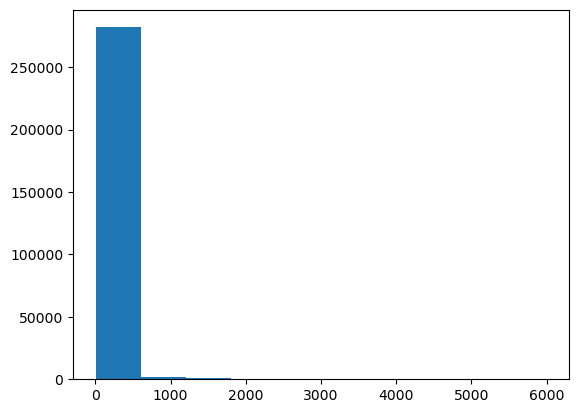

In [4]:
plt.hist(df.count_)

In [5]:
df[df.count_>=100]

rating_val,movie_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,count_,rating_1_4,rating_8_10
66,1-2013-1,2.127660,4.787234,7.978723,13.297872,21.276596,25.000000,12.234043,11.702128,1.595745,0.000000,188.0,28.191489,13.297872
124,10,0.512821,3.076923,5.128205,10.256410,14.358974,26.666667,20.512821,14.871795,2.564103,2.051282,195.0,18.974359,19.487179
136,10-65-self-mutilation,0.000000,0.990099,3.960396,1.980198,8.910891,20.792079,23.762376,26.732673,4.950495,7.920792,101.0,6.930693,39.603960
144,10-cloverfield-lane,0.223028,0.446055,0.696961,2.090884,4.014497,14.329523,26.456649,34.457764,12.740452,4.544187,3587.0,3.456928,51.742403
182,10-rillington-place,0.000000,0.000000,0.000000,0.729927,1.824818,11.678832,23.357664,45.620438,11.678832,5.109489,274.0,0.729927,62.408759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285931,zorba-the-greek,1.515152,0.000000,0.757576,2.272727,12.878788,18.939394,22.727273,25.757576,12.121212,3.030303,132.0,4.545455,40.909091
285939,zorns-lemma,1.503759,1.503759,2.255639,3.759398,6.015038,9.774436,15.789474,24.060150,18.796992,16.541353,133.0,9.022556,59.398496
285971,zu-warriors-from-the-magic-mountain,0.000000,0.000000,0.000000,3.225806,3.225806,14.838710,24.516129,35.483871,12.258065,6.451613,155.0,3.225806,54.193548
285992,zulu,0.326797,0.980392,1.307190,5.228758,6.209150,15.359477,23.529412,29.084967,13.071895,4.901961,306.0,7.843137,47.058824


In [6]:
mask_100 = df.count_>=100

list_100 = df[mask_100].movie_id.tolist()

## Density estimation

In [7]:
kde = KernelDensity(kernel='gaussian', bandwidth=4).fit(df.loc[mask_100,['rating_1_4','rating_8_10']])

In [8]:
df['love_hate_kde'] = np.nan

df.loc[mask_100,'love_hate_kde'] = kde.score_samples(df.loc[mask_100,['rating_1_4','rating_8_10']])

<Axes: xlabel='rating_1_4', ylabel='rating_8_10'>

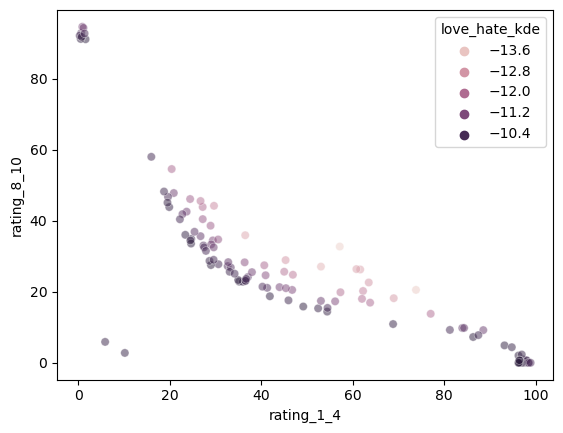

In [9]:
sns.scatterplot(
    data=df[mask_100 & (df.love_hate_kde<-10)],
    x='rating_1_4',
    y='rating_8_10',
    hue='love_hate_kde',
    alpha=.5
)


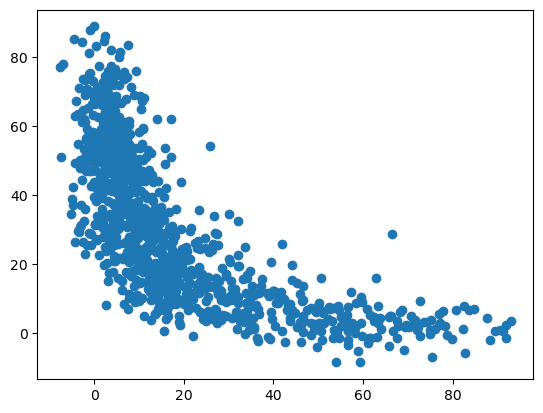

In [10]:
aux = list(zip(*kde.sample(1000)))
plt.scatter(
    aux[0],
    aux[1]
)

### Alternate approach

In [11]:
curve_x = np.arange(0,110,5)

curve_y = np.exp((100-curve_x)/5) / np.exp((100-curve_x)/5).sum() * 80 + 15

In [12]:
heatmap = np.histogram2d(
    df[mask_100].rating_1_4,
    df[mask_100].rating_8_10,
    bins=50,density=True)

<Axes: >

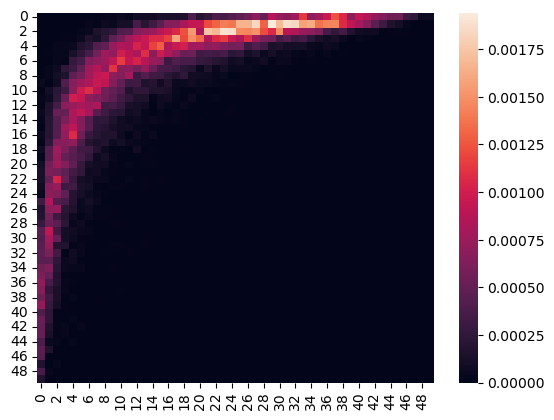

In [13]:
sns.heatmap(heatmap[0])

## Identification of films

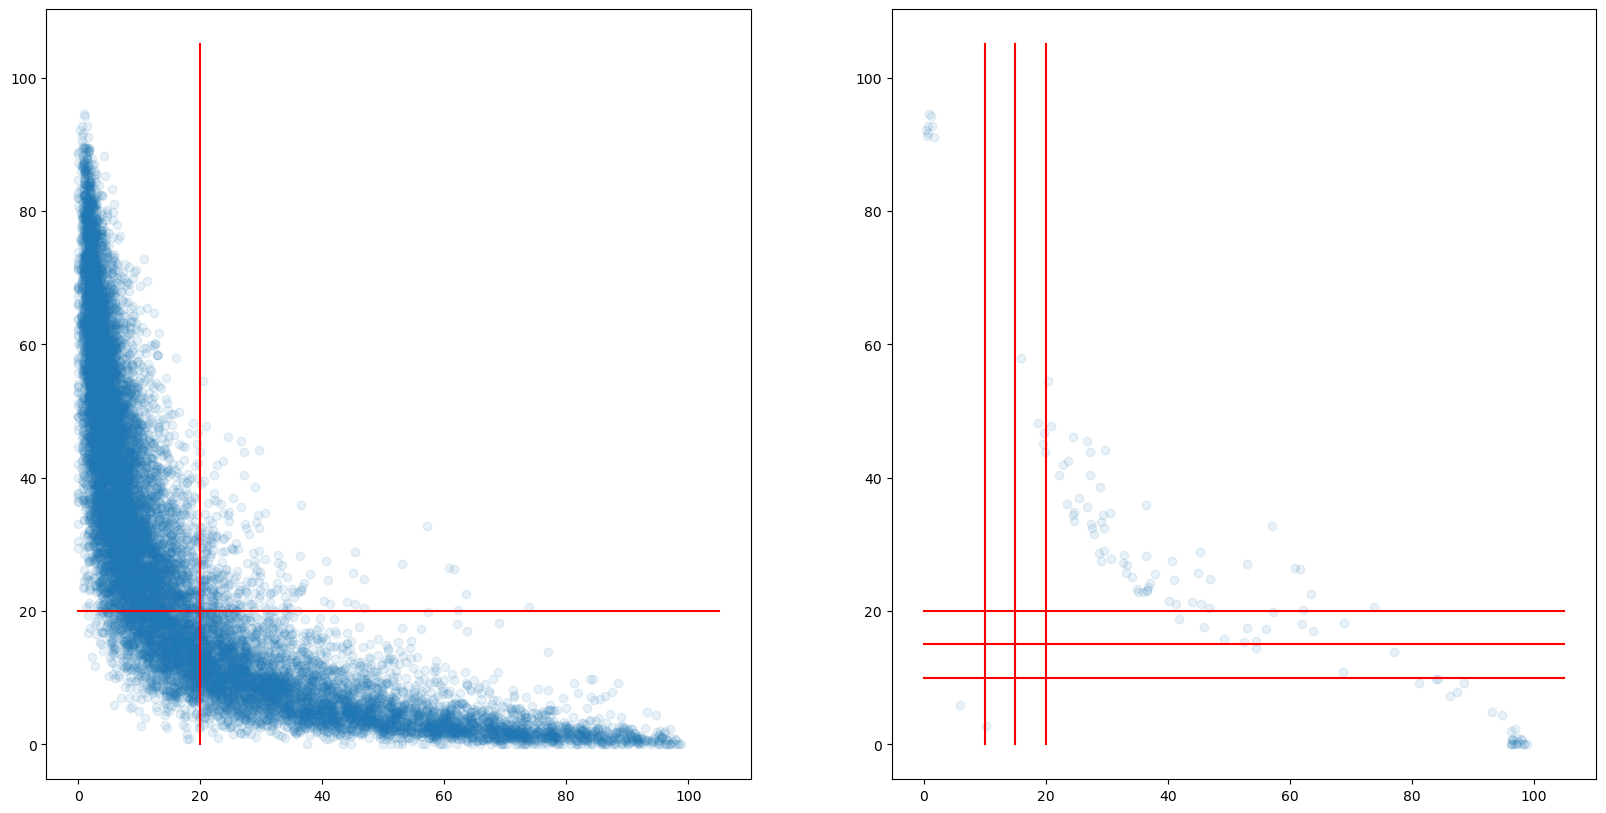

In [14]:
plt.figure(figsize=(20,10),
)
plt.ylim=(0,100)

plt.subplot(1,2,1)

#plt.plot(curve_x+20,curve_y,color='red')
plt.plot(    
    curve_x,
    [20]*len(curve_x),
#    25 - curve_x*(20/100),
    color='red'

)
plt.plot(    
    [20]*len(curve_x),
    curve_x,
#    25 - curve_x*(20/100),
    color='red'    
)
#plt.plot(    
#    curve_x,
#    50 - curve_x,
#    25 - curve_x*(20/100),
#    color='red'    
#)


plt.scatter(
    df[mask_100].rating_1_4,
    df[mask_100].rating_8_10,
    alpha=.1,
)


plt.subplot(1,2,2)

#plt.plot(curve_x+20,curve_y,color='red')
plt.plot(    
    curve_x,
    [20]*len(curve_x),
#    25 - curve_x*(20/100),
    color='red'

)
plt.plot(    
    [20]*len(curve_x),
    curve_x,
#    25 - curve_x*(20/100),
    color='red'    
)
plt.plot(    
    curve_x,
    [10]*len(curve_x),
#    25 - curve_x*(20/100),
    color='red'

)
plt.plot(    
    [10]*len(curve_x),
    curve_x,
#    25 - curve_x*(20/100),
    color='red'    
)#plt.plot(    
plt.plot(    
    curve_x,
    [15]*len(curve_x),
#    25 - curve_x*(20/100),
    color='red'

)
plt.plot(    
    [15]*len(curve_x),
    curve_x,
#    25 - curve_x*(20/100),
    color='red'    
)#plt.plot(    
#    curve_x,
#    50 - curve_x,
#    25 - curve_x*(20/100),
#    color='red'    
#)


plt.scatter(
    df[mask_100 & (df.love_hate_kde<-10)].rating_1_4,
    df[mask_100 & (df.love_hate_kde<-10)].rating_8_10,
    alpha=.1,
)



In [15]:
list_love_hate_movie = df[mask_100 & (df.love_hate_kde<-10.5) & (df.rating_1_4>20) & (df.rating_8_10>20)].sort_values('rating_8_10').movie_id.tolist()

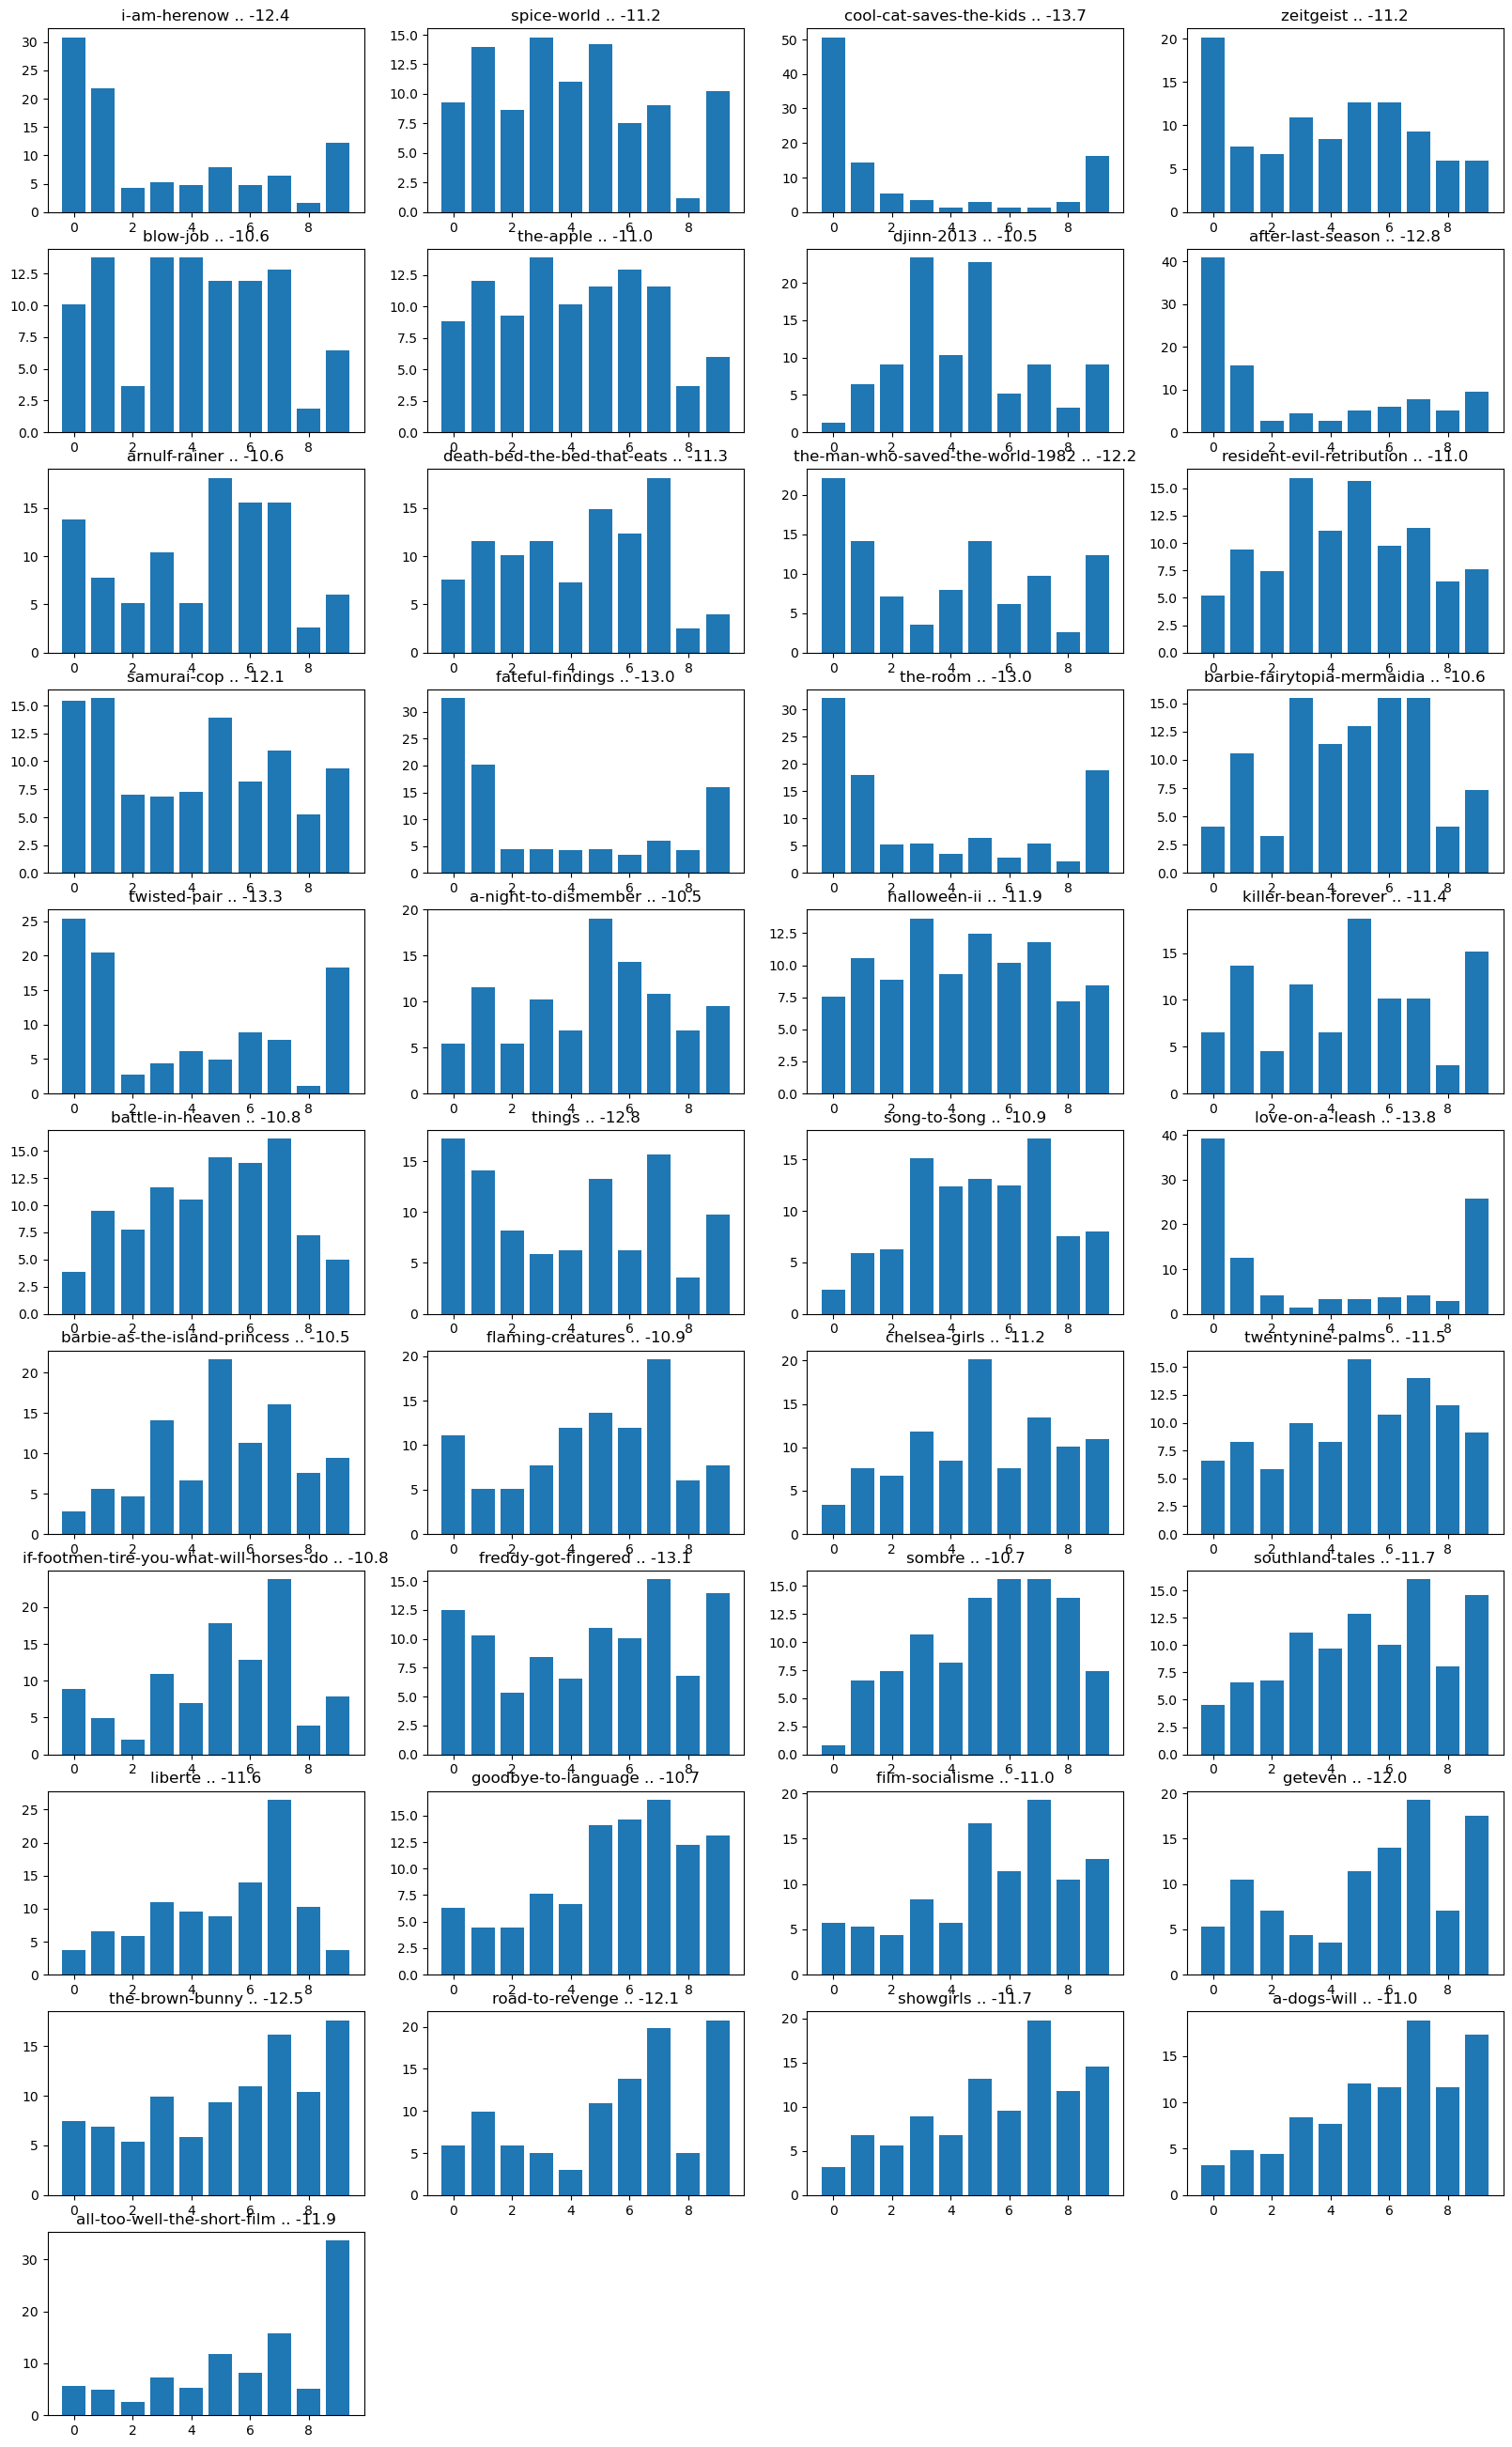

In [16]:
plt.figure(figsize=(20,3*11))

for i, movie in enumerate(list_love_hate_movie):
    plt.subplot(11,4,i+1)
    plt.bar(range(10),
            df.loc[df.movie_id==movie, ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10']].values[0]
           )
    plt.title(f'{movie} .. {np.round(df[df.movie_id==movie].love_hate_kde.values[0],1)}')

In [17]:
list_love_hate_movie_1 = df[mask_100 & (df.love_hate_kde<-9) & (df.rating_1_4>10) & (df.rating_8_10>10)].sort_values('love_hate_kde').head(44).movie_id.values.tolist()

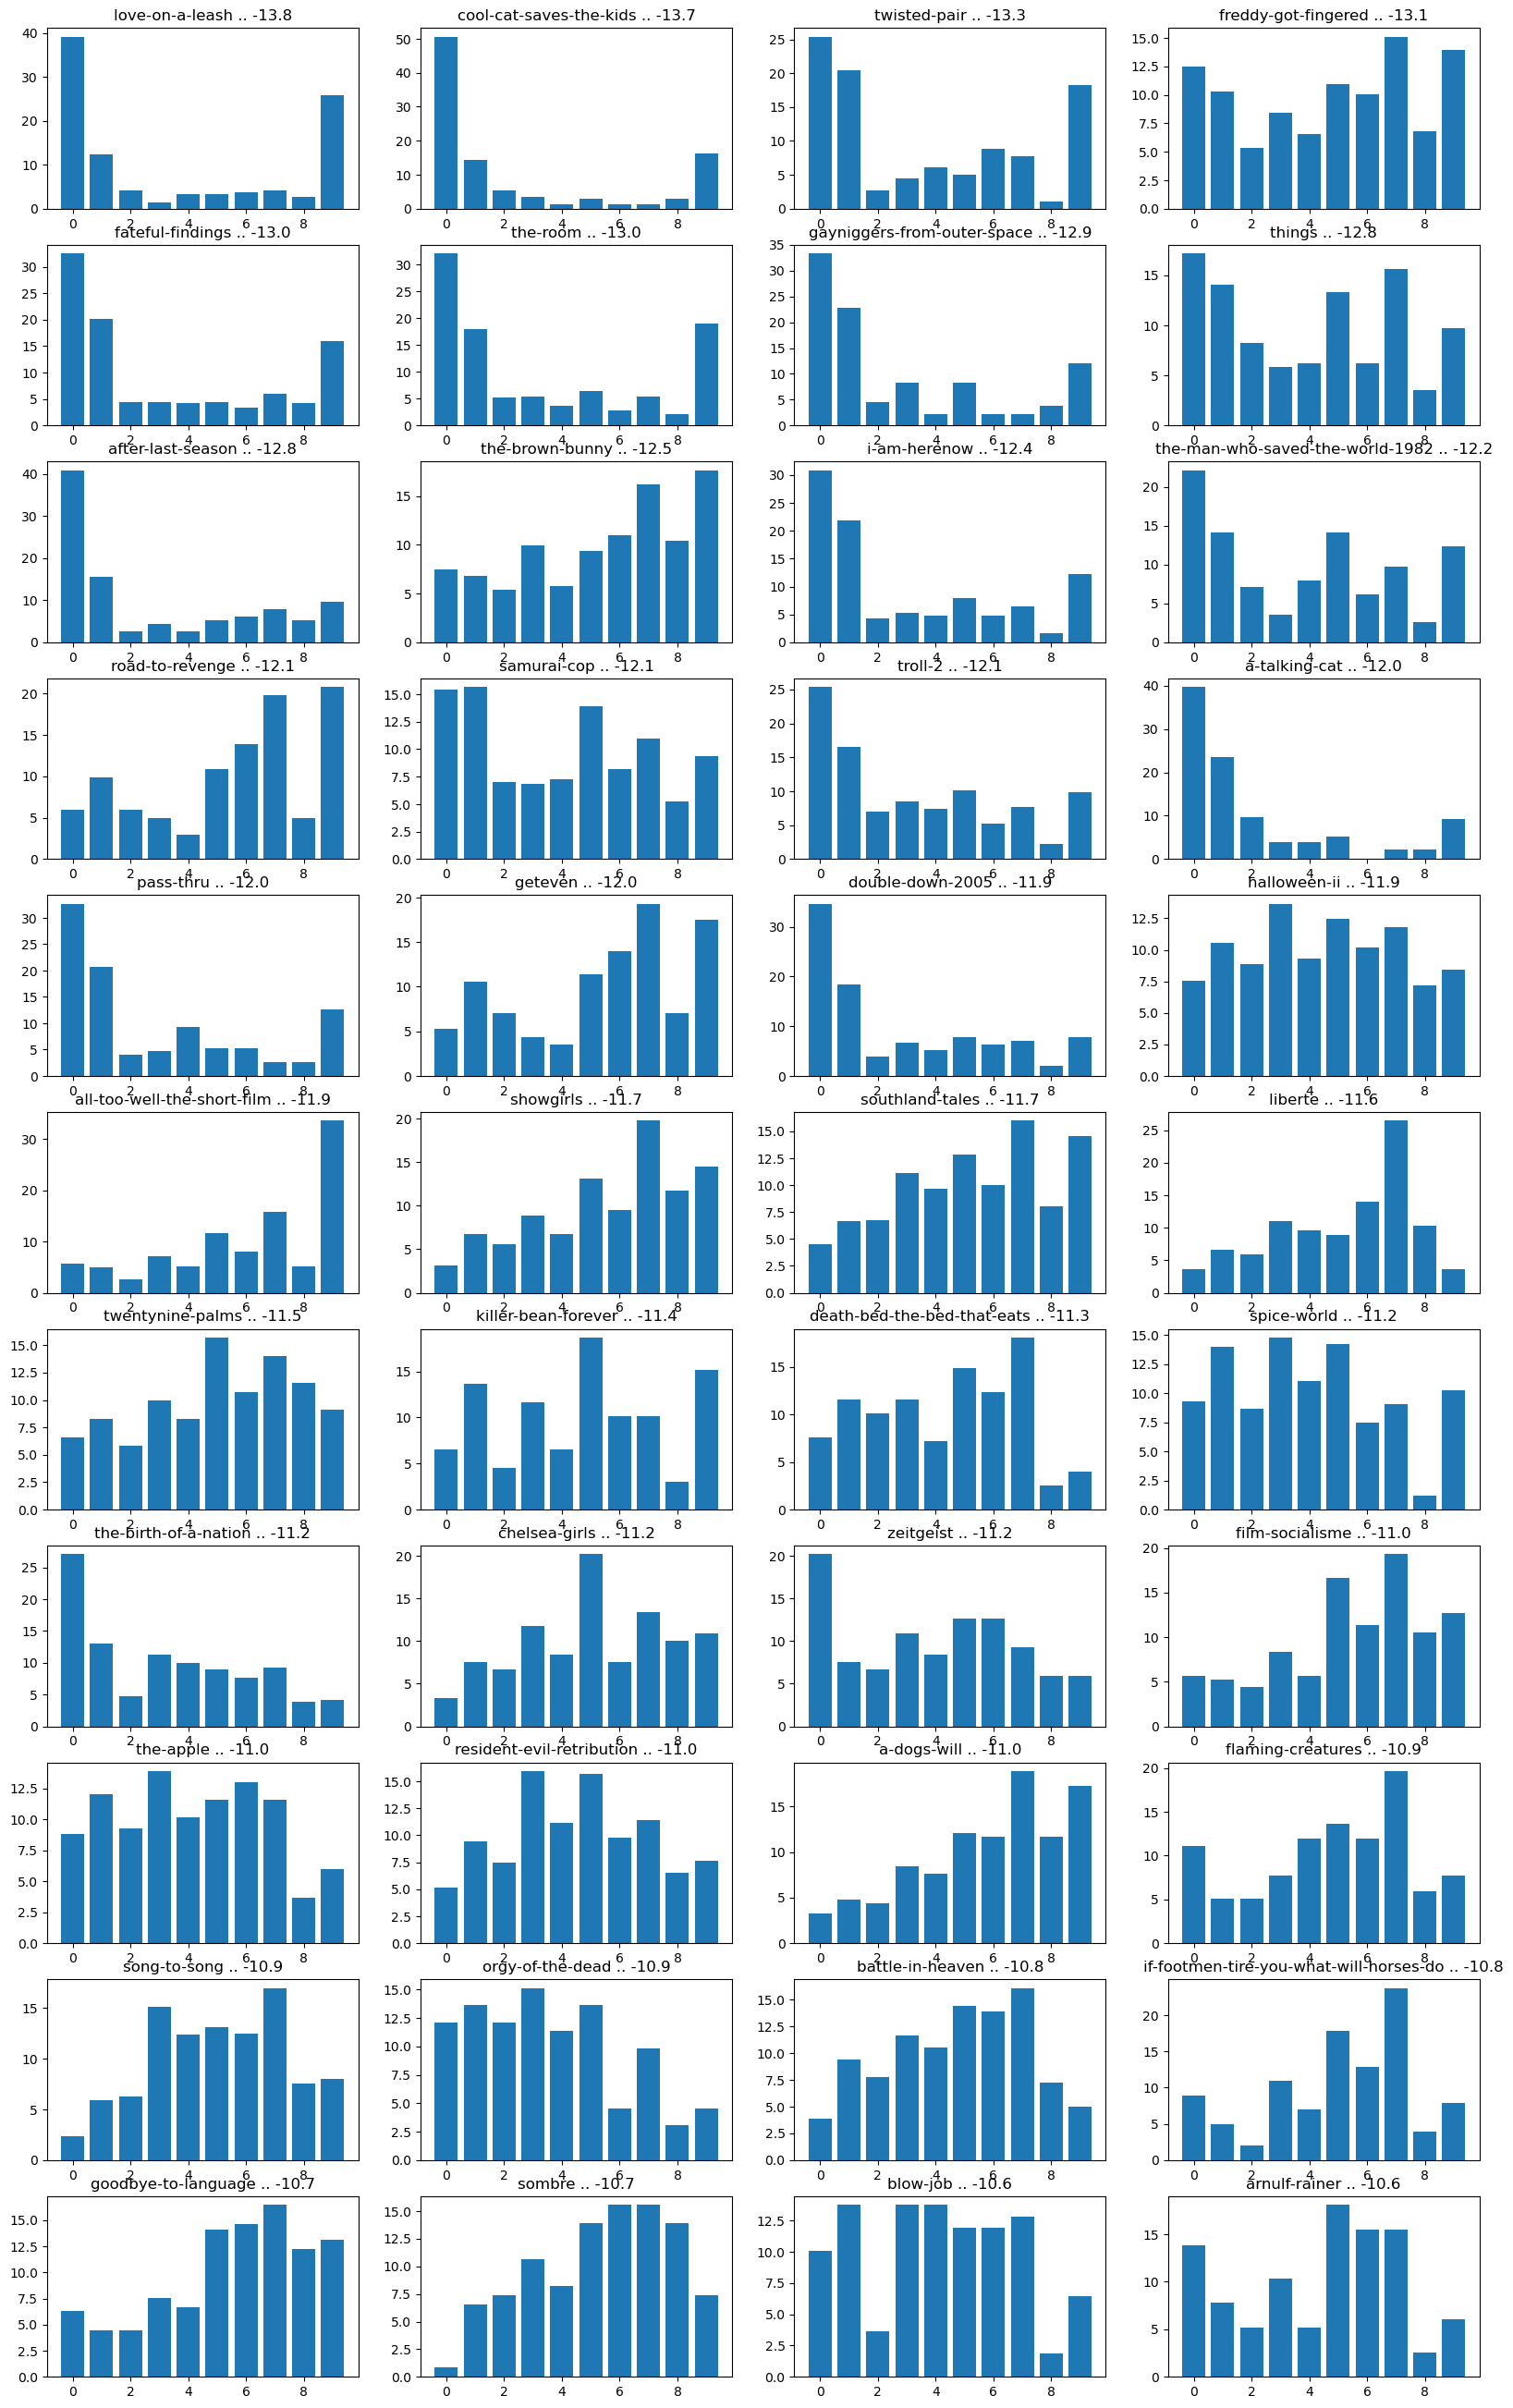

In [18]:
plt.figure(figsize=(20,3*11))

for i, movie in enumerate(list_love_hate_movie_1):
    plt.subplot(11,4,i+1)
    plt.bar(range(10),
            df.loc[df.movie_id==movie, ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10']].values[0]
           )
    plt.title(f'{movie} .. {np.round(df[df.movie_id==movie].love_hate_kde.values[0],1)}')

In [19]:
df[mask_100 & (df.love_hate_kde<-9) & (df.rating_1_4>15) & (df.rating_8_10>15)].sort_values('love_hate_kde').head(60)

rating_val,movie_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,count_,rating_1_4,rating_8_10,love_hate_kde
136519,love-on-a-leash,39.170507,12.442396,4.147465,1.382488,3.225806,3.225806,3.686636,4.147465,2.764977,25.806452,217.0,57.142857,32.718894,-13.817179
50806,cool-cat-saves-the-kids,50.655022,14.410480,5.240175,3.493450,1.310044,3.056769,1.310044,1.310044,3.056769,16.157205,229.0,73.799127,20.524017,-13.696281
266631,twisted-pair,25.414365,20.441989,2.762431,4.419890,6.077348,4.972376,8.839779,7.734807,1.104972,18.232044,181.0,53.038674,27.071823,-13.345031
86309,freddy-got-fingered,12.471132,10.277136,5.311778,8.429561,6.581986,10.969977,10.046189,15.127021,6.812933,13.972286,866.0,36.489607,35.912240,-13.101723
78365,fateful-findings,32.525253,20.202020,4.444444,4.444444,4.242424,4.444444,3.434343,6.060606,4.242424,15.959596,495.0,61.616162,26.262626,-13.013610
247327,the-room,32.079459,18.047337,5.283178,5.367709,3.592561,6.466610,2.789518,5.367709,2.071006,18.934911,2366.0,60.777684,26.373626,-13.013510
89290,gayniggers-from-outer-space,33.333333,22.727273,4.545455,8.333333,2.272727,8.333333,2.272727,2.272727,3.787879,12.121212,132.0,68.939394,18.181818,-12.870076
258190,things,17.187500,14.062500,8.203125,5.859375,6.250000,13.281250,6.250000,15.625000,3.515625,9.765625,256.0,45.312500,28.906250,-12.782955
11670,after-last-season,40.869565,15.652174,2.608696,4.347826,2.608696,5.217391,6.086957,7.826087,5.217391,9.565217,115.0,63.478261,22.608696,-12.762116
220260,the-brown-bunny,7.468880,6.846473,5.394191,9.958506,5.809129,9.336100,10.995851,16.182573,10.373444,17.634855,482.0,29.668050,44.190871,-12.548133


In [20]:
df[mask_100 & (df.love_hate_kde<-9) & (df.rating_1_4>15) & (df.rating_8_10>15)].sort_values('love_hate_kde').head(50)\
    .rename(columns={'movie_id':'Title'})\
    .Title.str.replace('-',' ')\
    .to_csv('data/50_love_or_hate_movies.csv',index=False)

## Extra

In [21]:
ratings_stats = ratings.groupby(['movie_id'])\
    .agg(
        rating_mean=('rating_val', lambda x: np.mean(x)),
        rating_var=('rating_val', lambda x: np.var(x)),
    )\
    .reset_index()

ratings_stats.head()

,movie_id,rating_mean,rating_var
0,0-uhr-15-zimmer-9,5.000000,0.000000
1,00-00,3.000000,8.000000
2,00-08,5.631579,4.653740
3,00-schneider-im-wendekreis-der-eidechse,6.733333,3.395556
4,00-schneider-jagd-auf-nihil-baxter,6.080000,8.473600


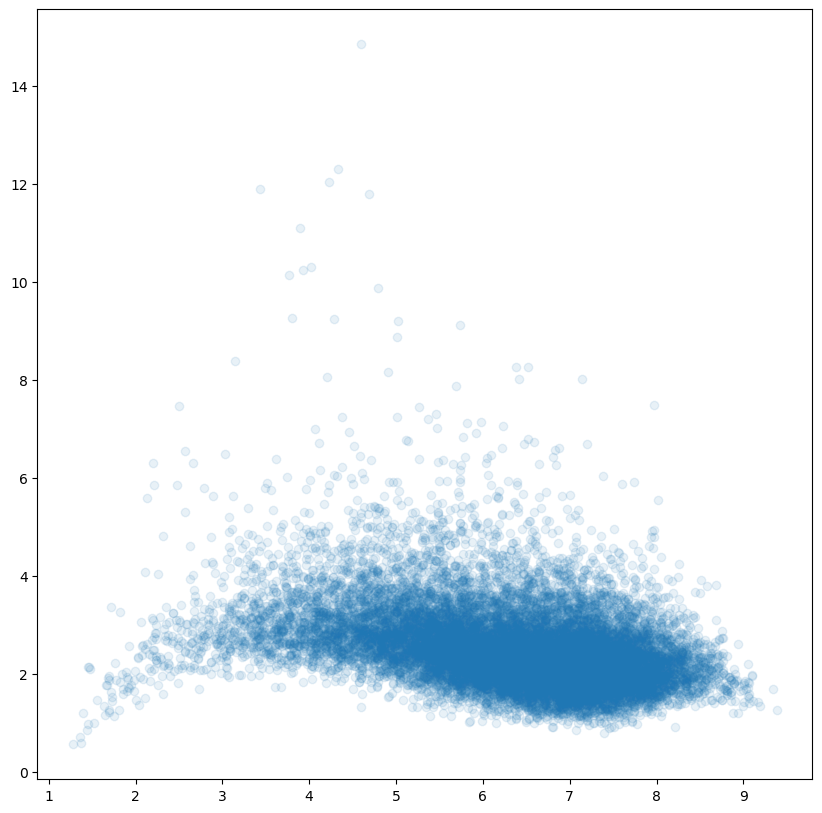

In [22]:
mask_stats_100 = ratings_stats.movie_id.isin(list_100)

plt.figure(figsize=(10,10))
plt.scatter(
    ratings_stats[mask_stats_100].rating_mean,
    ratings_stats[mask_stats_100].rating_var,
    alpha=.1
)